In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tvb.simulator.lab import *
import types

In [ ]:
# This second version of the code uses a simple 2-region connectivity matrix
# and runs the simulation in slices of 20 s each, for a total of 60 s.
# This version configures once, and swaps the connectivity weights for each iteration.


# below is what the user has to provide: connectivity matrices and the duration of each slice
connectivities = np.stack([
    np.array([[2.3, 0.9],
              [-1.2, -0.5]],),
    np.array([[0.0, 0.0],
              [0.0, 0.0],]),
    np.array([[-4.4, 1.6],
              [0.8, -2.2]],)
], axis=2)

slice_dur = 20_000.0  # ms, constant for every slice


# Discover dimensions
n_regions, _, n_slices = connectivities.shape

# Auto‐build labels and dummy centres
region_labels = np.array([f"R{i+1}" for i in range(n_regions)], dtype="<U128")
centres       = np.array([[1.0, 0.0, 1.0],
                          [0.0, 0.0, 1.0]], dtype=np.float32)


# 1) Build one Connectivity object (we’ll swap its weights in place)
conn = connectivity.Connectivity(
    weights       = connectivities[..., 0],
    tract_lengths = np.ones((n_regions, n_regions)),
    region_labels = region_labels,
    centres       = centres
)

# 2) Instantiate & configure the low‐level Simulator once
sim = simulator.Simulator(
    model       = models.Generic2dOscillator(),
    connectivity= conn,
    coupling    = coupling.Linear(a=np.array([0.0126])),     # scalar coupling
    integrator  = integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(nsig=np.array([0.001]))),
    monitors    = (monitors.TemporalAverage(period=1.0),
                   monitors.Bold(period=1000.0)),
)
sim.configure()

# 3) (Optional) Monkey‐patch to log only on actual connectivity changes
sim._last_weights = None
_original = sim._loop_compute_node_coupling

def _logged_compute(self, step):
    w = self.connectivity.weights
    if self._last_weights is None or not np.array_equal(w, self._last_weights):
        print(f"[Step {step}] connectivity.weights changed to:\n{w}\n")
        self._last_weights = w.copy()
    return _original(step)

sim._loop_compute_node_coupling = types.MethodType(_logged_compute, sim)

# 4) Loop through all slices, swapping in each connectivity
all_times = []
all_bold  = []
all_tavg_times = []
all_tavg_data  = []


for k in range(n_slices):
    # swap in the k-th connectivity
    sim.connectivity.weights = connectivities[..., k]
    print(f"Running slice {k+1}/{n_slices} with weights:\n{connectivities[..., k]}\n")

    # run this slice
    sim.simulation_length = slice_dur
    (t_tavg, d_tavg), (t_b, d_b) = sim.run()  

    all_times.append(t_b)  
    all_bold.append(d_b)
    all_tavg_times.append(t_tavg) 
    all_tavg_data.append(d_tavg)

# 5) Concatenate into full outputs
full_time = np.concatenate(all_times)
full_bold = np.concatenate(all_bold, axis=0)

full_tavg_time = np.concatenate(all_tavg_times)
full_tavg_data = np.concatenate(all_tavg_data, axis=0)


# Now full_time and full_bold cover all slices seamlessly


Running slice 1/3 with weights:
[[ 2.3  0.9]
 [-1.2 -0.5]]

[Step 1] connectivity.weights changed to:
[[ 2.3  0.9]
 [-1.2 -0.5]]

Running slice 2/3 with weights:
[[0. 0.]
 [0. 0.]]

[Step 20001] connectivity.weights changed to:
[[0. 0.]
 [0. 0.]]

Running slice 3/3 with weights:
[[-4.4  1.6]
 [ 0.8 -2.2]]

[Step 40001] connectivity.weights changed to:
[[-4.4  1.6]
 [ 0.8 -2.2]]



In [ ]:
print(full_bold)

print(full_tavg_data)

In [4]:
# Check if the time axis is continuous

dts = np.diff(full_time)
if np.all(dts == 1000.0):
    print("✅ Time axis is continuous: all Δt = 1000 ms")
else:
    bad = np.where(dts != 1000.0)[0]
    for idx in bad:
        print(f"⚠️  Gap or overlap at index {idx}: "
              f"{full_time[idx]} → {full_time[idx+1]} = {dts[idx]} ms")

✅ Time axis is continuous: all Δt = 1000 ms


Text(0.5, 0, 'Time (ms)')

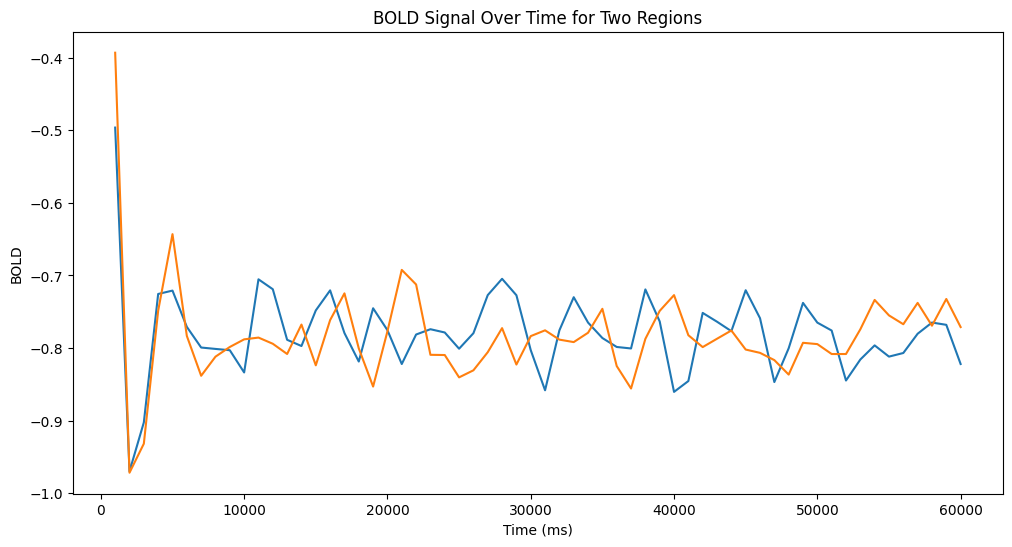

In [34]:
plt.figure(figsize=(12, 6))

plt.plot(full_time, full_bold[:, 0, :, 0])
plt.ylabel("BOLD")
plt.title("BOLD Signal Over Time for Two Regions")
plt.xlabel('Time (ms)')

Text(0.5, 0, 'Time (ms)')

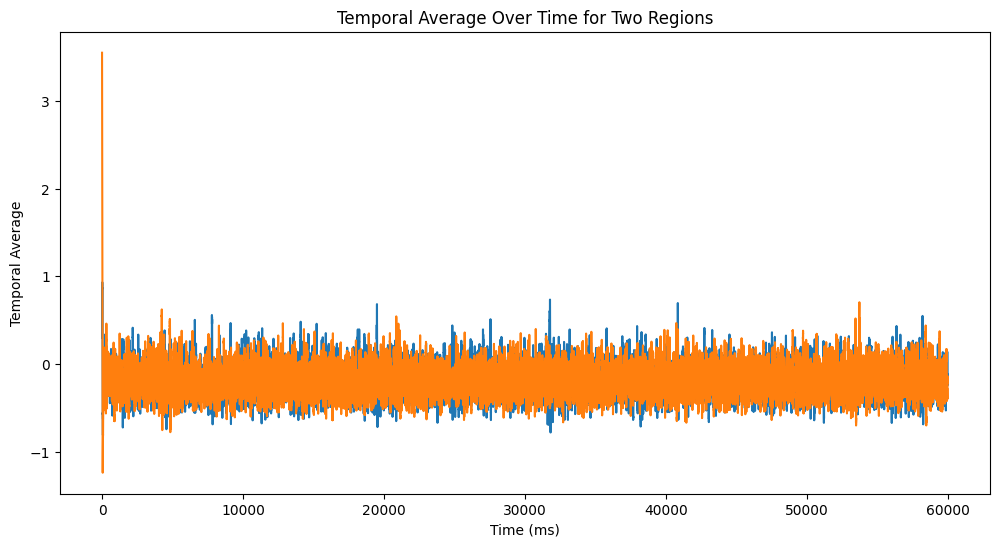

In [35]:
plt.figure(figsize=(12, 6))

plt.plot(full_tavg_time, full_tavg_data[:, 0, :, 0])
plt.ylabel("Temporal Average")
plt.title("Temporal Average Over Time for Two Regions")
plt.xlabel('Time (ms)')

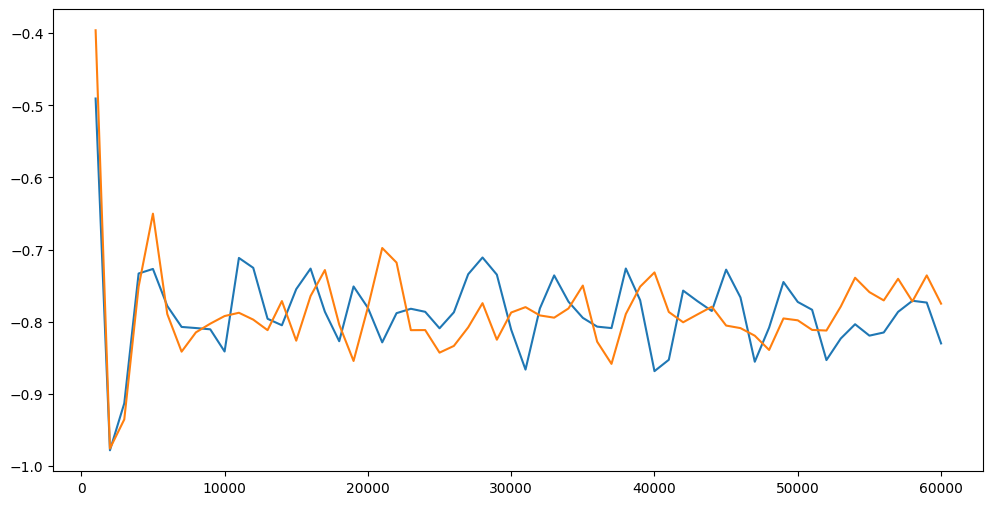

In [24]:
# compare time-varying connectivity simulation with a static one


conn = connectivity.Connectivity(
    weights       = connectivities[..., 0],
    tract_lengths = np.ones((n_regions, n_regions)),
    region_labels = region_labels,
    centres       = centres
)

# 2) Instantiate & configure the low‐level Simulator once
sim = simulator.Simulator(
    model       = models.Generic2dOscillator(),
    connectivity= conn,
    coupling    = coupling.Linear(a=np.array([0.0126])),     # scalar coupling
    integrator  = integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(nsig=np.array([0.001]))),
    monitors    = (monitors.TemporalAverage(period=1.0),
                   monitors.Bold(period=1000.0)),
    simulation_length=60e3
)
sim.configure()

(t_tavg_static, d_tavg_static), (t_b_static, d_b_static) = sim.run() 

plt.figure(figsize=(12, 6))

plt.plot(t_b_static, d_b_static[:, 0, :, 0])
